In [18]:
from feast import FeatureStore
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from joblib import dump
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# Getting our FeatureStore
store = FeatureStore(repo_path=".")

In [7]:
# Retrieving the saved dataset and converting it to a DataFrame
training_df = store.get_saved_dataset(name="churn_dataset").to_df()

In [8]:
training_df

,HasCrCard,USER_ID,IsActiveMember,Age,CreditScore,event_timestamp,Balance,Tenure,Geography_Germany,Gender,Geography_Spain,Geography_France,Exited,NumOfProducts,EstimatedSalary
0,0,9195,0,40,613,2023-01-01 00:00:00+00:00,124339.90,7,False,1,False,True,0,1,193309.58
1,1,7283,0,44,581,2023-01-01 00:00:00+00:00,189318.16,7,False,0,True,False,1,2,45026.23
2,1,1520,1,64,544,2023-01-01 00:00:00+00:00,124043.80,3,False,0,False,True,1,1,111402.97
3,0,8200,1,32,810,2023-01-01 00:00:00+00:00,120879.73,9,False,1,False,True,0,2,78896.59
4,1,4167,0,45,850,2023-01-01 00:00:00+00:00,174088.30,5,False,0,True,False,1,4,5669.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,829,1,31,630,2023-12-31 00:00:00+00:00,112373.49,2,True,0,False,False,0,2,131167.98
9996,0,4605,1,25,681,2023-12-31 00:00:00+00:00,0.00,5,False,1,False,True,0,1,90860.97
9997,1,6850,1,44,716,2023-12-31 00:00:00+00:00,0.00,1,False,0,False,True,0,1,152108.47
9998,0,1527,0,34,711,2023-12-31 00:00:00+00:00,0.00,8,False,1,False,True,0,2,48260.19


In [9]:
# Separating the features and labels
labels = training_df['Exited']
features = training_df.drop(
    labels=['Exited', 'event_timestamp', "USER_ID"],
    axis=1)

In [10]:
# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    stratify=labels)

### Train 1 - Random Forest Classifier

In [24]:
# Inizializza il modello
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Addestra il modello
model.fit(X=X_train, y=y_train)

RandomForestClassifier(random_state=42)

In [25]:
dump(model, "random_forest_model.pkl")

['random_forest_model.pkl']

### Train 2 - Logistic Regression Classifier

In [0]:
# Define the hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300]
}

In [13]:
# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to your data
grid_search.fit(X=X_train, y=y_train)

C:\Users\claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10, 100], 'max_iter': [100, 200, 300],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy')

In [14]:
# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Parameters: ", best_params)
print("Best Estimator: ", best_estimator)

Best Parameters:  {'C': 1, 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Estimator:  LogisticRegression(C=1, max_iter=200)


In [15]:
# Make predictions and evaluate your model
y_pred = best_estimator.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: ", accuracy)

Test Accuracy:  0.8192


In [16]:
# Saving the model
dump(value=grid_search, filename="model_2.joblib")

['model_2.joblib']

### Confronto tra i due modelli

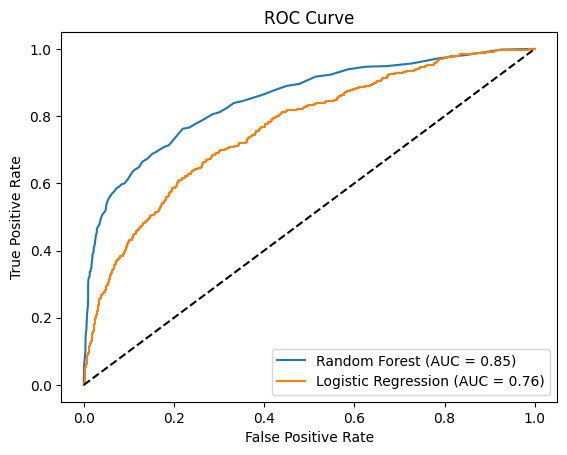

In [26]:
# Calcoliamo le probabilità predette per la classe positiva su enrambi i modelli (con e senza PCA)
y_pred_prob_1 = model.predict_proba(X_test)[:, 1]
y_pred_prob_2 = grid_search.predict_proba(X_test)[:,-1]

# Calcoliamo la curva ROC e l'AUC relativo all'albero senza PCA appena addestrato
fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, y_pred_prob_1)
auc_1 = roc_auc_score(y_test, y_pred_prob_1)

# Calcoliamo la curva ROC e l'AUC relativo all'albero con PCA appena addestrato
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_pred_prob_2)
auc_2 = roc_auc_score(y_test, y_pred_prob_2)

# Plottiamo la curva ROC dei due modelli (alberi con e senza PCA) per comparare le performance
plt.plot(fpr_1, tpr_1, label=f'Random Forest (AUC = {auc_1:.2f})')
plt.plot(fpr_2, tpr_2, label=f'Logistic Regression (AUC = {auc_2:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()